In [1]:
import tensorflow as tf
print(tf.__version__)

1.15.0


python3.7.17
pip3 install tensorflow==1.15
pip3 install protobuf==3.20.*
pip3 install stable_baselines==2.10
pip3 install "gym==0.19.0"

USE gym-battlesnake, not BattlesnakeGym

In [2]:
# Load up our dependencies
import numpy as np
import math
import random
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load up our dependencies
import numpy as np
import math
import random
import os
import time
import matplotlib.pyplot as plt
import gym

from a2c_ppo_acktr.algo import PPO
from a2c_ppo_acktr.model import Policy, NNBase
from a2c_ppo_acktr.storage import RolloutStorage
from collections import deque
from gym_battlesnake.gymbattlesnake import BattlesnakeEnv

from tqdm.notebook import tqdm

device = torch.device('cuda')

In [3]:
# From https://github.com/fastai/fastai2/blob/master/fastai2/vision/models/xresnet.py
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

# See: https://github.com/ikostrikov/pytorch-a2c-ppo-acktr-gail/blob/master/a2c_ppo_acktr/model.py
# for examples
        
class SnakePolicyBase(NNBase):
    ''' Neural Network Policy for our snake. This is the brain '''
    # hidden_size must equal the output size of the policy_head
    def __init__(self, num_inputs, recurrent=False, hidden_size=128): 
        super().__init__(recurrent, hidden_size, hidden_size)
        
        # We'll define a 3-stack CNN with leaky_relu activations and a batchnorm
        # here.
        self.base = nn.Sequential(
            nn.Conv2d(18, 32, 3),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3),
            nn.LeakyReLU(),
        )
        
        # Try yourself: Try different pooling methods
        # We add a pooling layer since it massively speeds up training
        # and reduces the number of parameters to learn.
        self.pooling = nn.AdaptiveMaxPool2d(2)
        
        # Try yourself: Change the number of features
        # 64 channels * 4x4 pooling outputs = 1024
        self.fc1 = nn.Linear(in_features=32*2*2, out_features=128)
        
        # Value head predicts how good the current board is
        self.value_head = nn.Linear(in_features=128, out_features=1)
        
        # Policy network gives action probabilities
        # The output of this is fed into a fully connected layer with 4 outputs
        # (1 for each possible direction)
        self.policy_head = nn.Linear(in_features=128, out_features=128)
        
        # Use kaiming initialization in our feature layers
        init_cnn(self)
        
    def forward(self, obs, rnn_hxs, masks):
        out = F.leaky_relu(self.base(obs))
        out = self.pooling(out).view(-1, 128)
        out = F.leaky_relu(self.fc1(out))
        
        value_out = self.value_head(out)
        policy_out = self.policy_head(out)
        
        return value_out, policy_out, rnn_hxs
    
class PredictionPolicy(Policy):
    """ Simple class that wraps the packaged policy with the prediction method needed by the gym """

    def predict(self, inputs, deterministic=False):
        # Since this called from our gym environment
        # (and passed as a numpy array), we need to convert it to a tensor
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        value, actor_features, rnn_hxs = self.base(inputs, None, None)
        dist = self.dist(actor_features)

        if deterministic:
            action = dist.mode()
        else:
            action = dist.sample()

        return action, value
        
def create_policy(obs_space, act_space, base):
    """ Returns a wrapped policy for use in the gym """
    return PredictionPolicy(obs_space, act_space, base=base)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
def save_policy(policy, path):
    torch.save(policy.state_dict(), path)

def load_policy(policy, path):
    policy.load_state_dict(torch.load(path))
    return policy

In [5]:
# Number of parallel environments to generate games in
n_envs = 200
# Number of steps per environment to simulate
n_steps = 600

# The total training set size per iteration is n_envs * n_steps

# The gym environment
env = BattlesnakeEnv(n_threads=1, n_envs=n_envs)

# Storage for rollouts (game turns played and the rewards)
rollouts = RolloutStorage(n_steps,
                          n_envs,
                          env.observation_space.shape,
                          env.action_space,
                          n_steps)
env.close()

# Create our policy as defined above
policy = create_policy(env.observation_space.shape, env.action_space, SnakePolicyBase)
best_old_policy = create_policy(env.observation_space.shape, env.action_space, SnakePolicyBase)

# Lets make the old policy the same as the current one
best_old_policy.load_state_dict(policy.state_dict())

# OR LOAD A SAVED MODEL
# ie: policy = torch.load('saved_models/my_model.pt')

agent = PPO(policy,
            value_loss_coef=0.5,
            entropy_coef=0.01,
            max_grad_norm=0.5,
            clip_param=0.2,
            ppo_epoch=4,
            num_mini_batch=32,
            eps=1e-5,
            lr=1e-3)

In [6]:
# Let's figure out how many trainable parameters our network has:
print(f"Trainable Parameters: {count_parameters(policy)}")

Trainable Parameters: 57381


In [7]:
# Let's define a method to check our performance against an older policy
# Determines an unbiased winrate check
def check_performance(current_policy, opponent, n_opponents=2, n_envs=1000, steps=1500, device=torch.device('cpu')):
    test_env = BattlesnakeEnv(n_threads=os.cpu_count(), n_envs=n_envs, opponents=[opponent for _ in range(2)], device=device, teammates=[policy])
    obs = test_env.reset()
    wins = 0
    losses = 0
    completed = np.zeros(n_envs)
    count = 0
    lengths = []
    with torch.no_grad():
        # Simulate to a maximum steps across our environments, only recording the first result in each env.
        print("Running performance check")
        for step in tqdm(range(steps)):
            if count == n_envs:
                # Quick break
                print("Check Performance done @ step", step)
                break
            inp = torch.tensor(obs, dtype=torch.float32).to(device)
            action, _ = current_policy.predict(inp, deterministic=True)
            obs, reward, done, info = test_env.step(action.cpu().numpy().flatten())
            for i in range(test_env.n_envs):
                if completed[i] == 1:
                    continue # Only count each environment once
                if 'episode' in info[i]:
                    if info[i]['episode']['r'] == 1:
                        completed[i] = 1
                        count += 1
                        wins += 1
                        lengths.append(info[i]['episode']['l'])
                    elif info[i]['episode']['r'] == -1:
                        completed[i] = 1
                        losses += 1
                        count += 1
                        lengths.append(info[i]['episode']['l'])

    winrate = wins / n_envs
    print("Wins", wins)
    print("Losses", losses)
    print("Average episode length:", np.mean(lengths))
    return winrate

In [11]:
import torch
import numpy as np
import time
from tqdm import tqdm
import random

# Initialization of necessary variables and placeholders
env = BattlesnakeEnv(n_threads=8, n_envs=n_envs, opponents=[policy for _ in range(2)], device=device, teammates=[policy])
best_old_policy.load_state_dict(policy.state_dict())
obs = env.reset()
rollouts.obs[0].copy_(torch.tensor(obs))
num_updates = 1000
policy.to(device)
best_old_policy.to(device)
rollouts.to(device)
rewards = []
value_losses = []
lengths = []
prior_best_models = [best_old_policy]  # Initialize the list with the first best model
start = time.time()

for j in range(num_updates):
    episode_rewards = []
    episode_lengths = []
    # Set the policy to evaluation mode
    policy.eval()
    print(f"Iteration {j+1}: Generating rollouts")

    # Determine the opponents for this iteration
    if random.random() < 0.8:
        opponents = [policy for _ in range(2)]  # Use the current best model 80% of the time
    else:
        prior_best_opponent = random.choice(prior_best_models)  # Use a prior best model 20% of the time
        opponents = [prior_best_opponent for _ in range(2)]
    teammates = [policy]
    
    # Create a new environment instance with the selected opponents
    env = BattlesnakeEnv(n_threads=8, n_envs=n_envs, opponents=opponents, device=device, teammates=[policy])
    obs = env.reset()
    rollouts.obs[0].copy_(torch.tensor(obs))

    for step in tqdm(range(n_steps)):
        with torch.no_grad():
            value, action, action_log_prob, recurrent_hidden_states = policy.act(
                rollouts.obs[step],
                rollouts.recurrent_hidden_states[step],
                rollouts.masks[step]
            )
        obs, reward, done, infos = env.step(action.cpu().squeeze())
        obs = torch.tensor(obs)
        reward = torch.tensor(reward).unsqueeze(1)

        for info in infos:
            if 'episode' in info.keys():
                episode_rewards.append(info['episode']['r'])
                episode_lengths.append(info['episode']['l'])

        masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
        bad_masks = torch.FloatTensor([[0.0] if 'bad_transition' in info.keys() else [1.0] for info in infos])
        rollouts.insert(obs, recurrent_hidden_states, action, action_log_prob, value, reward, masks, bad_masks)

    with torch.no_grad():
        next_value = policy.get_value(
            rollouts.obs[-1],
            rollouts.recurrent_hidden_states[-1],
            rollouts.masks[-1]
        ).detach()
        
    policy.train()
    print("Training policy on rollouts...")
    rollouts.compute_returns(next_value, True, 0.99, 0.95, False)
    value_loss, action_loss, dist_entropy = agent.update(rollouts)
    rollouts.after_update()
    policy.eval()
    total_num_steps = (j + 1) * n_envs * n_steps
    end = time.time()
    
    lengths.append(np.mean(episode_lengths))
    rewards.append(np.mean(episode_rewards))
    value_losses.append(value_loss)
    
    if (j+1) % 10 == 0:
        print("\n")
        print("=" * 80)
        print("Iteration", j+1, "Results")
        winrate = check_performance(policy, best_old_policy, device=torch.device(device))
        print(f"Winrate vs prior best: {winrate*100:.2f}%")
        print(f"Median Length: {np.median(episode_lengths)}")
        print(f"Max Length: {np.max(episode_lengths)}")
        print(f"Min Length: {np.min(episode_lengths)}")

        if winrate > 0.51:
            print("Policy winrate is > 51%. Updating prior best model")
            best_old_policy.load_state_dict(policy.state_dict())
            prior_best_models.append(best_old_policy)  # Add the current best model to the list of prior best models
            save_policy(policy, 'saved_models/my_model.pt')
        else:
            print("Policy has not learned enough yet... keep training!")
        print("-" * 80)


Iteration 1: Generating rollouts


100%|██████████| 600/600 [00:12<00:00, 46.58it/s]


Training policy on rollouts...
Iteration 2: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 54.83it/s]


Training policy on rollouts...
Iteration 3: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 55.33it/s]


Training policy on rollouts...
Iteration 4: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 56.01it/s]


Training policy on rollouts...
Iteration 5: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 56.27it/s]


Training policy on rollouts...
Iteration 6: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 55.68it/s]


Training policy on rollouts...
Iteration 7: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 55.65it/s]


Training policy on rollouts...
Iteration 8: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 56.47it/s]


Training policy on rollouts...
Iteration 9: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 55.53it/s]


Training policy on rollouts...
Iteration 10: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 56.91it/s]


Training policy on rollouts...


Iteration 10 Results
Running performance check


 32%|███▏      | 474/1500 [00:39<01:24, 12.12it/s]


Check Performance done @ step 474
Wins 655
Losses 345
Average episode length: 99.083
Winrate vs prior best: 65.50%
Median Length: 6.0
Max Length: 491
Min Length: 2
Policy winrate is > 51%. Updating prior best model
--------------------------------------------------------------------------------
Iteration 11: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 56.98it/s]


Training policy on rollouts...
Iteration 12: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 56.03it/s]


Training policy on rollouts...
Iteration 13: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 56.87it/s]


Training policy on rollouts...
Iteration 14: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 56.77it/s]


Training policy on rollouts...
Iteration 15: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 56.79it/s]


Training policy on rollouts...
Iteration 16: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 56.51it/s]


Training policy on rollouts...
Iteration 17: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 56.64it/s]


Training policy on rollouts...
Iteration 18: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 57.05it/s]


Training policy on rollouts...
Iteration 19: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 55.89it/s]


Training policy on rollouts...
Iteration 20: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 56.81it/s]


Training policy on rollouts...


Iteration 20 Results
Running performance check


 34%|███▍      | 508/1500 [00:43<01:24, 11.73it/s]


Check Performance done @ step 508
Wins 750
Losses 250
Average episode length: 78.062
Winrate vs prior best: 75.00%
Median Length: 6.0
Max Length: 467
Min Length: 2
Policy winrate is > 51%. Updating prior best model
--------------------------------------------------------------------------------
Iteration 21: Generating rollouts


100%|██████████| 600/600 [00:10<00:00, 56.95it/s]


Training policy on rollouts...


KeyboardInterrupt: 

In [ ]:
# # We'll play 4-way matches
# env = BattlesnakeEnv(n_threads=8, n_envs=n_envs, opponents=[policy for _ in range(2)], device=device, teammates=[policy])
# obs = env.reset()
# rollouts.obs[0].copy_(torch.tensor(obs))

# # How many iterations do we want to run
# num_updates = 1500

# # Send our network and storage to the gpu
# policy.to(device)
# best_old_policy.to(device)
# rollouts.to(device)

# # Record mean values to plot at the end
# rewards = []
# value_losses = []
# lengths = []

# start = time.time()
# for j in range(num_updates):
#     episode_rewards = []
#     episode_lengths = []
#     # Set
#     policy.eval()
#     print(f"Iteration {j+1}: Generating rollouts")
#     for step in tqdm(range(n_steps)):
#         with torch.no_grad():
#             value, action, action_log_prob, recurrent_hidden_states = policy.act(rollouts.obs[step],
#                                                             rollouts.recurrent_hidden_states[step],
#                                                             rollouts.masks[step])
#         obs, reward, done, infos = env.step(action.cpu().squeeze())
#         obs = torch.tensor(obs)
#         reward = torch.tensor(reward).unsqueeze(1)

#         for info in infos:
#             if 'episode' in info.keys():
#                 episode_rewards.append(info['episode']['r'])
#                 episode_lengths.append(info['episode']['l'])

#         masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
#         bad_masks = torch.FloatTensor([[0.0] if 'bad_transition' in info.keys() else [1.0] for info in infos])
#         rollouts.insert(obs, recurrent_hidden_states, action, action_log_prob, value, reward, masks, bad_masks)

#     with torch.no_grad():
#         next_value = policy.get_value(
#             rollouts.obs[-1],
#             rollouts.recurrent_hidden_states[-1],
#             rollouts.masks[-1]
#         ).detach()
        
#     # Set the policy to be in training mode (switches modules to training mode for things like batchnorm layers)
#     policy.train()

#     print("Training policy on rollouts...")
#     # We're using a gamma = 0.99 and lambda = 0.95
#     rollouts.compute_returns(next_value, True, 0.99, 0.95, False)
#     value_loss, action_loss, dist_entropy = agent.update(rollouts)
#     rollouts.after_update()

#     # Set the policy into eval mode (for batchnorms, etc)
#     policy.eval()
    
#     total_num_steps = (j + 1) * n_envs * n_steps
#     end = time.time()
    
#     lengths.append(np.mean(episode_lengths))
#     rewards.append(np.mean(episode_rewards))
#     value_losses.append(value_loss)
    
#     # Every 5 iterations, we'll print out the episode metrics
#     if (j+1) % 5 == 0:
#         print("\n")
#         print("=" * 80)
#         print("Iteration", j+1, "Results")
#         # Check the performance of the current policy against the prior best
#         winrate = check_performance(policy, best_old_policy, device=torch.device(device))
#         print(f"Winrate vs prior best: {winrate*100:.2f}%")
#         print(f"Median Length: {np.median(episode_lengths)}")
#         print(f"Max Length: {np.max(episode_lengths)}")
#         print(f"Min Length: {np.min(episode_lengths)}")

#         # If our policy wins more than 30% of the games against the prior
#         # best opponent, update the prior best.
#         # Expected outcome for equal strength players is 25% winrate in a 4 player
#         # match.
#         if winrate > 0.50:
#             print("Policy winrate is > 50%. Updating prior best model")
#             best_old_policy.load_state_dict(policy.state_dict())
#             save_policy(policy, 'saved_models/my_model.pt')
#         else:
#             print("Policy has not learned enough yet... keep training!")
#         print("-" * 80)

NameError: name 'lengths' is not defined

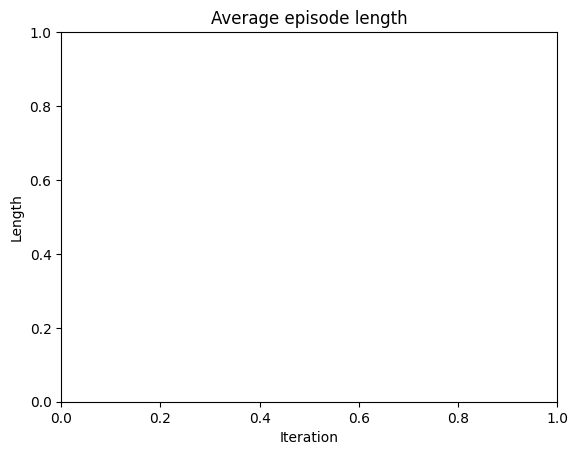

In [18]:
plt.clf()
plt.title("Average episode length")
plt.ylabel("Length")
plt.xlabel("Iteration")
plt.plot(lengths)
plt.show()

plt.title("Average episode reward")
plt.ylabel("Reward")
plt.xlabel("Iteration")
plt.plot(rewards)
plt.show()

In [ ]:
save_policy(policy, 'saved_models/my_model.pt')

In [10]:
policy = load_policy(policy, 'saved_models/my_model.pt')

In [26]:
# To watch a replay, we need an environment
# Important: Make sure to use fixed orientation during visualization
playground = BattlesnakeEnv(n_threads=1, n_envs=1, opponents=[policy for _ in range(2)], fixed_orientation=True, teammates=[policy], device=torch.device("cpu"))

In [27]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def obs_to_frame(obs):
    ''' Converts an environment observation into a renderable RGB image '''
    # First, let's find the game board dimensions from layer 5
    x_offset, y_offset = 0, 0
    done = False
    for x in range(23):
        if done:
            break
        for y in range(23):
            if obs[0][5][x][y] == 1:
                x_offset = x
                y_offset = y
                done = True
                break
    output = np.zeros((11, 11, 3), dtype=np.uint8)

    # See https://github.com/cbinners/gym-battlesnake/blob/master/gym_battlesnake/src/gamewrapper.cpp#L55 for
    # layer reference
    for x in range(23):
        for y in range(23):
            # Render snake bodies
            if obs[0][1][x][y] == 1:
                output[x-x_offset][y-y_offset] = 255 - 10*(255 - obs[0][2][x][y])
            # Render food
            if obs[0][4][x][y] == 1:
                output[x-x_offset][y-y_offset][0] = 255
                output[x-x_offset][y-y_offset][1] = 255
                output[x-x_offset][y-y_offset][2] = 0
            # Render snake heads as a red pixel
            if obs[0][0][x][y] > 0:
                output[x-x_offset][y-y_offset][0] = 255
                output[x-x_offset][y-y_offset][1] = 0
                output[x-x_offset][y-y_offset][2] = 0
            # Render snake heads
            if obs[0][6][x][y] == 1:
                output[x-x_offset][y-y_offset][0] = 0
                output[x-x_offset][y-y_offset][1] = 255
                output[x-x_offset][y-y_offset][2] = 0

    return output

# Reset the environment 
obs = playground.reset()

# Keep track of game frames to render
video = []

# Grab a set of frames to render
with torch.no_grad():
    for i in tqdm(range(300)):
        # Add the rendered observation to our frame stack
        video.append(obs_to_frame(obs))

        # Get the action our policy should take
        _, action, _, _ = policy.act(torch.tensor(obs, dtype=torch.float32).to('cpu'), None, None)

        # Perform our action and update our observation
        obs,_,_,_ = playground.step(action.cpu().squeeze())

# Render, adapted from here: https://stackoverflow.com/questions/57060422/fast-way-to-display-video-from-arrays-in-jupyter-lab

video = np.array(video, dtype=np.uint8)
fig = plt.figure()
im = plt.imshow(video[0,:,:,:])
plt.close()
def init():
    im.set_data(video[0,:,:,:])
def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0], interval=200)
HTML(anim.to_html5_video())

  0%|          | 0/300 [00:00<?, ?it/s]

/home/karlo/.pyenv/versions/3.7.17/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
